In [1]:
import torch.cuda
import sys

sys.path.append('..')
SEED=1

from src.henry.mnist_vae_pure import VariationalAutoencoder
import torchvision
import torchvision.datasets as datasets
import pickle
from matplotlib import pyplot as plt
import numpy as np
from utils import * 
from WeightsModification import * 
from federated_pure import federate




In [2]:
class FakeArgs:
    def __init__(self):
        self.seed=42
        self.epochs = 10
        self.dataset = "mnist"
        self.num_users=5
        self.iid = 2
        self.dirichlet = 0.5 
        self.local_ep=5
        self.local_bs=64
        self.beta=1.0
    

In [3]:
# vae, ovr_losses, mse_losses, kl_losses = vae.train_model(dataset_train,16,10)
# print(mse_losses)
# print(kl_losses)
# 46 -> 34
res = federate(FakeArgs())
res.serialise("base_no_beta",FakeArgs())





/home/henry/anaconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 5, average loss across batches: 585.4447372600597
Finished local epoch 2 out of 5, average loss across batches: 541.0752632387223
Finished local epoch 3 out of 5, average loss across batches: 532.9034279443885
Finished local epoch 4 out of 5, average loss across batches: 528.8728737779843
Finished local epoch 5 out of 5, average loss across batches: 526.5106614635837
(Test Set) user 0 in round 1 totalL: 139.84803560374377 mseL: 138.40965322232756 klL: 1.4383823897429349
Training user 1 in round 1
Finished local epoch 1 out of 5, average loss across batches: 653.0282694498698
Finished local epoch 2 out of 5, average loss across batches: 577.8880745216652
Finished local epoch 3 out of 5, average loss across batches: 568.9624289053457
Finished local epoch 4 out of 5, average loss across batches: 564.5683865017361
Finished local epoch 5 out of 5, average loss across batches: 561.1334369800709
(Test Se

 10%|█         | 1/10 [01:20<12:05, 80.60s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 646.8453204681397

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 5, average loss across batches: 533.6135865898542
Finished local epoch 2 out of 5, average loss across batches: 514.5861522715579
Finished local epoch 3 out of 5, average loss across batches: 511.46324617119245
Finished local epoch 4 out of 5, average loss across batches: 509.03162293793054
Finished local epoch 5 out of 5, average loss across batches: 507.47779747747603
(Test Set) user 0 in round 2 totalL: 135.45457672709338 mseL: 133.96111473960303 klL: 1.4934620458541141
Training user 1 in round 2
Finished local epoch 1 out of 5, average loss across batches: 598.1284801341869
Finished local epoch 2 out of 5, average loss across batches: 566.3159716570818
Finished local epoch 3 out of 5, average loss across batches: 561.3425151683666
Finished local epoch 4 out of 5, average loss across batches: 557.6378592031973
Finished local epoch 5 out of 5

 20%|██        | 2/10 [02:40<10:43, 80.47s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 586.6076307189942

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 5, average loss across batches: 513.7619018554688
Finished local epoch 2 out of 5, average loss across batches: 504.55118388514364
Finished local epoch 3 out of 5, average loss across batches: 502.6469457482779
Finished local epoch 4 out of 5, average loss across batches: 501.26578464302963
Finished local epoch 5 out of 5, average loss across batches: 499.6216045092511
(Test Set) user 0 in round 3 totalL: 133.1712902175415 mseL: 131.7088342637245 klL: 1.4624559610301457
Training user 1 in round 3
Finished local epoch 1 out of 5, average loss across batches: 578.9941807499638
Finished local epoch 2 out of 5, average loss across batches: 559.2160022876881
Finished local epoch 3 out of 5, average loss across batches: 555.4980672200521
Finished local epoch 4 out of 5, average loss across batches: 552.933029739945
Finished local epoch 5 out of 5, av

 30%|███       | 3/10 [04:01<09:22, 80.32s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 548.631498298645

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 5, average loss across batches: 503.7846443422379
Finished local epoch 2 out of 5, average loss across batches: 498.25706547562794
Finished local epoch 3 out of 5, average loss across batches: 496.86692744429394
Finished local epoch 4 out of 5, average loss across batches: 495.34444665396086
Finished local epoch 5 out of 5, average loss across batches: 494.61823215279526
(Test Set) user 0 in round 4 totalL: 132.09818228573332 mseL: 130.51042601386106 klL: 1.5877563033595674
Training user 1 in round 4
Finished local epoch 1 out of 5, average loss across batches: 564.3315237539786
Finished local epoch 2 out of 5, average loss across batches: 552.6062192563658
Finished local epoch 3 out of 5, average loss across batches: 548.8255858244719
Finished local epoch 4 out of 5, average loss across batches: 546.8268780178494
Finished local epoch 5 out of 5

 40%|████      | 4/10 [05:21<08:01, 80.31s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 534.9445433013916

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 5, average loss across batches: 498.83182369765416
Finished local epoch 2 out of 5, average loss across batches: 494.803955242198
Finished local epoch 3 out of 5, average loss across batches: 492.9435472385858
Finished local epoch 4 out of 5, average loss across batches: 491.8291178057271
Finished local epoch 5 out of 5, average loss across batches: 490.95466892693634
(Test Set) user 0 in round 5 totalL: 131.39579536767798 mseL: 129.61194332471615 klL: 1.7838520508129636
Training user 1 in round 5
Finished local epoch 1 out of 5, average loss across batches: 555.7340850830078
Finished local epoch 2 out of 5, average loss across batches: 549.0367106684932
Finished local epoch 3 out of 5, average loss across batches: 545.7145835028755
Finished local epoch 4 out of 5, average loss across batches: 544.0182681613499
Finished local epoch 5 out of 5, 

 50%|█████     | 5/10 [06:40<06:39, 79.98s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 528.3599200942994

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 5, average loss across batches: 495.42582276046915
Finished local epoch 2 out of 5, average loss across batches: 491.22932663784235
Finished local epoch 3 out of 5, average loss across batches: 488.90905269499746
Finished local epoch 4 out of 5, average loss across batches: 488.0976716728621
Finished local epoch 5 out of 5, average loss across batches: 487.5945326282132
(Test Set) user 0 in round 6 totalL: 130.72429736760512 mseL: 129.14223003632384 klL: 1.58206732302249
Training user 1 in round 6
Finished local epoch 1 out of 5, average loss across batches: 551.6665824607567
Finished local epoch 2 out of 5, average loss across batches: 545.5157046847874
Finished local epoch 3 out of 5, average loss across batches: 543.0411410861545
Finished local epoch 4 out of 5, average loss across batches: 542.224375406901
Finished local epoch 5 out of 5, a

 60%|██████    | 6/10 [08:00<05:19, 79.97s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 524.5535369903564

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 5, average loss across batches: 491.7127085039693
Finished local epoch 2 out of 5, average loss across batches: 488.1958291658791
Finished local epoch 3 out of 5, average loss across batches: 486.49333092474166
Finished local epoch 4 out of 5, average loss across batches: 485.3952137936828
Finished local epoch 5 out of 5, average loss across batches: 484.96478337113575
(Test Set) user 0 in round 7 totalL: 130.5414980409696 mseL: 128.7780448906976 klL: 1.7634532002322534
Training user 1 in round 7
Finished local epoch 1 out of 5, average loss across batches: 547.5239817301432
Finished local epoch 2 out of 5, average loss across batches: 542.2662771719473
Finished local epoch 3 out of 5, average loss across batches: 540.5269978841146
Finished local epoch 4 out of 5, average loss across batches: 539.4666691532841
Finished local epoch 5 out of 5, a

 70%|███████   | 7/10 [09:21<04:00, 80.07s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 521.1272794525147

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 5, average loss across batches: 489.4119989538705
Finished local epoch 2 out of 5, average loss across batches: 486.6166253858997
Finished local epoch 3 out of 5, average loss across batches: 485.1985549106393
Finished local epoch 4 out of 5, average loss across batches: 484.6749223278415
Finished local epoch 5 out of 5, average loss across batches: 484.3106339977634
(Test Set) user 0 in round 8 totalL: 130.03067468792727 mseL: 128.34093435369792 klL: 1.6897403694148163
Training user 1 in round 8
Finished local epoch 1 out of 5, average loss across batches: 546.9259132102684
Finished local epoch 2 out of 5, average loss across batches: 541.3374681825991
Finished local epoch 3 out of 5, average loss across batches: 539.721472563567
Finished local epoch 4 out of 5, average loss across batches: 538.2877233999747
Finished local epoch 5 out of 5, av

 80%|████████  | 8/10 [10:41<02:40, 80.16s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 520.1416580703735

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 5, average loss across batches: 487.9776868922736
Finished local epoch 2 out of 5, average loss across batches: 484.72044979628697
Finished local epoch 3 out of 5, average loss across batches: 483.8425868864982
Finished local epoch 4 out of 5, average loss across batches: 482.8003658171623
Finished local epoch 5 out of 5, average loss across batches: 481.9561219574303
(Test Set) user 0 in round 9 totalL: 129.4784456240158 mseL: 127.81108688430324 klL: 1.6673587867544917
Training user 1 in round 9
Finished local epoch 1 out of 5, average loss across batches: 545.1238024676287
Finished local epoch 2 out of 5, average loss across batches: 539.5065290662977
Finished local epoch 3 out of 5, average loss across batches: 538.0573320742006
Finished local epoch 4 out of 5, average loss across batches: 537.5360994692202
Finished local epoch 5 out of 5, a

 90%|█████████ | 9/10 [12:00<01:19, 79.88s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 518.1590222946166

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 5, average loss across batches: 487.22168969595305
Finished local epoch 2 out of 5, average loss across batches: 483.97589570732526
Finished local epoch 3 out of 5, average loss across batches: 482.77901614609584
Finished local epoch 4 out of 5, average loss across batches: 482.1559800999139
Finished local epoch 5 out of 5, average loss across batches: 481.5156715967322
(Test Set) user 0 in round 10 totalL: 129.85907477697592 mseL: 128.1113021651516 klL: 1.7477726162076945
Training user 1 in round 10
Finished local epoch 1 out of 5, average loss across batches: 544.013306511773
Finished local epoch 2 out of 5, average loss across batches: 538.6226066306785
Finished local epoch 3 out of 5, average loss across batches: 537.4915231775354
Finished local epoch 4 out of 5, average loss across batches: 536.3223540694626
Finished local epoch 5 out of

100%|██████████| 10/10 [13:19<00:00, 79.94s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 517.1427721740723
TRAINING ALL DONE!


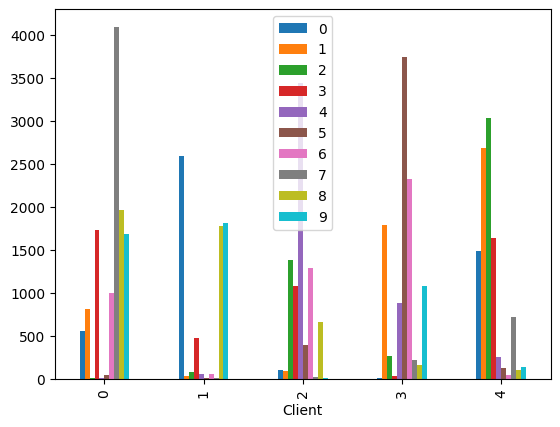

In [4]:
ClientDatasetManager.plot_dataset_splits(res.client_datasets)


In [5]:
res.global_model = res.global_model.to('cuda')

In [6]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to('cuda')
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

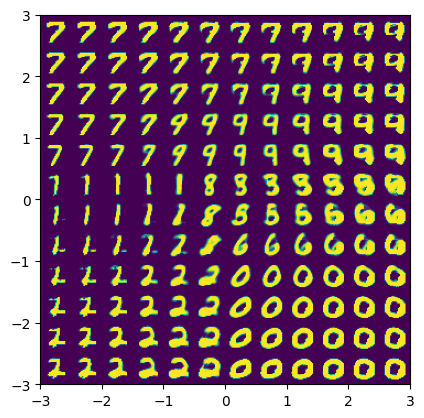

In [7]:
plot_reconstructed(res.global_model, r0=(-3, 3), r1=(-3, 3))


In [76]:
trial_weights = calculate_new_weights(res.global_model.encoder, res.client_datasets, 0.05,0.0)


In [77]:
print(f"Original Weights: {calculate_relative_dataset_sizes(res.client_datasets)}")
print(f"New Weights: {trial_weights}")

Original Weights: [0.24778115754823118, 0.1438184924371849, 0.17623650985457728, 0.21917579899162465, 0.21298804116838202]
New Weights: [0.2522405632788246, 0.12904355569242473, 0.17983021680297692, 0.22402957468322843, 0.21485608954254526]


In [78]:
second_res = federate(FakeArgs(), trial_weights, res.client_datasets)
second_res.serialise("point_one",FakeArgs())


  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 5, average loss across batches: 585.4447372600597
Finished local epoch 2 out of 5, average loss across batches: 541.0752632387223
Finished local epoch 3 out of 5, average loss across batches: 532.9034279443885
Finished local epoch 4 out of 5, average loss across batches: 528.8728737779843
Finished local epoch 5 out of 5, average loss across batches: 526.5106614635837
(Test Set) user 0 in round 1 totalL: 142.36493050226798 mseL: 140.90066104090613 klL: 1.4642694698384249
Training user 1 in round 1
Finished local epoch 1 out of 5, average loss across batches: 653.0282694498698
Finished local epoch 2 out of 5, average loss across batches: 577.8880745216652
Finished local epoch 3 out of 5, average loss across batches: 568.9624289053457
Finished local epoch 4 out of 5, average loss across batches: 564.5683865017361
Finished local epoch 5 out of 5, average loss across batches: 561.1334369800709
(Test Se

 10%|█         | 1/10 [01:27<13:07, 87.47s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 647.0580087982178

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 5, average loss across batches: 533.5640281759282
Finished local epoch 2 out of 5, average loss across batches: 515.1284919656733
Finished local epoch 3 out of 5, average loss across batches: 511.73285437142977
Finished local epoch 4 out of 5, average loss across batches: 509.41350662067373
Finished local epoch 5 out of 5, average loss across batches: 507.86963825841104
(Test Set) user 0 in round 2 totalL: 137.8915033303164 mseL: 136.34161183701713 klL: 1.5498914498910876
Training user 1 in round 2
Finished local epoch 1 out of 5, average loss across batches: 597.6731250904224
Finished local epoch 2 out of 5, average loss across batches: 564.4712405734592
Finished local epoch 3 out of 5, average loss across batches: 558.7477530020254
Finished local epoch 4 out of 5, average loss across batches: 555.3407776444046
Finished local epoch 5 out of 5,

 20%|██        | 2/10 [02:45<10:55, 81.94s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 581.65384241333

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 5, average loss across batches: 512.8815770303049
Finished local epoch 2 out of 5, average loss across batches: 504.10513125183763
Finished local epoch 3 out of 5, average loss across batches: 501.91185079595095
Finished local epoch 4 out of 5, average loss across batches: 500.4640381515667
Finished local epoch 5 out of 5, average loss across batches: 499.2686708511845
(Test Set) user 0 in round 3 totalL: 135.6142314572201 mseL: 134.05165943791053 klL: 1.5625719910202545
Training user 1 in round 3
Finished local epoch 1 out of 5, average loss across batches: 576.642921730324
Finished local epoch 2 out of 5, average loss across batches: 557.4837646484375
Finished local epoch 3 out of 5, average loss across batches: 554.1004440872757
Finished local epoch 4 out of 5, average loss across batches: 552.5548248291016
Finished local epoch 5 out of 5, ave

 30%|███       | 3/10 [04:02<09:16, 79.50s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 545.5246722610474

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 5, average loss across batches: 503.30718977733324
Finished local epoch 2 out of 5, average loss across batches: 498.31031520392304
Finished local epoch 3 out of 5, average loss across batches: 496.66624270203295
Finished local epoch 4 out of 5, average loss across batches: 495.2639371810421
Finished local epoch 5 out of 5, average loss across batches: 493.8586886826382
(Test Set) user 0 in round 4 totalL: 134.54567153996857 mseL: 132.90764861948685 klL: 1.6380229027948825
Training user 1 in round 4
Finished local epoch 1 out of 5, average loss across batches: 563.4796396891276
Finished local epoch 2 out of 5, average loss across batches: 552.0026019061053
Finished local epoch 3 out of 5, average loss across batches: 548.7816902443215
Finished local epoch 4 out of 5, average loss across batches: 547.0642166137695
Finished local epoch 5 out of 5

 40%|████      | 4/10 [05:18<07:50, 78.44s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 533.7025306533814

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 5, average loss across batches: 498.6115566786899
Finished local epoch 2 out of 5, average loss across batches: 494.8689253612231
Finished local epoch 3 out of 5, average loss across batches: 493.0788818687521
Finished local epoch 4 out of 5, average loss across batches: 492.03220621744794
Finished local epoch 5 out of 5, average loss across batches: 491.4297158846291
(Test Set) user 0 in round 5 totalL: 134.0799967288206 mseL: 132.3484083548038 klL: 1.73158837947135
Training user 1 in round 5
Finished local epoch 1 out of 5, average loss across batches: 556.5503127486618
Finished local epoch 2 out of 5, average loss across batches: 549.5818546436451
Finished local epoch 3 out of 5, average loss across batches: 547.2545440108688
Finished local epoch 4 out of 5, average loss across batches: 545.7665908248337
Finished local epoch 5 out of 5, aver

 50%|█████     | 5/10 [06:37<06:32, 78.54s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 527.3985674743652

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 5, average loss across batches: 495.33544364026795
Finished local epoch 2 out of 5, average loss across batches: 491.79797921129455
Finished local epoch 3 out of 5, average loss across batches: 490.269035093246
Finished local epoch 4 out of 5, average loss across batches: 489.40970816663514
Finished local epoch 5 out of 5, average loss across batches: 488.1164342408539
(Test Set) user 0 in round 6 totalL: 133.4059419277737 mseL: 131.70677248887438 klL: 1.6991694686860888
Training user 1 in round 6
Finished local epoch 1 out of 5, average loss across batches: 552.7649626555266
Finished local epoch 2 out of 5, average loss across batches: 547.2622643929941
Finished local epoch 3 out of 5, average loss across batches: 545.2454282972548
Finished local epoch 4 out of 5, average loss across batches: 544.7200218483254
Finished local epoch 5 out of 5, 

 60%|██████    | 6/10 [08:01<05:20, 80.23s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 524.0577841079712

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 5, average loss across batches: 493.12402507823003
Finished local epoch 2 out of 5, average loss across batches: 489.2841286607968
Finished local epoch 3 out of 5, average loss across batches: 487.07984645392304
Finished local epoch 4 out of 5, average loss across batches: 486.939220633558
Finished local epoch 5 out of 5, average loss across batches: 485.75429214969756
(Test Set) user 0 in round 7 totalL: 133.34206501495183 mseL: 131.6754347557429 klL: 1.666630259238996
Training user 1 in round 7
Finished local epoch 1 out of 5, average loss across batches: 550.7841220431858
Finished local epoch 2 out of 5, average loss across batches: 544.9392095495153
Finished local epoch 3 out of 5, average loss across batches: 542.2305925157335
Finished local epoch 4 out of 5, average loss across batches: 541.2734490853769
Finished local epoch 5 out of 5, a

 70%|███████   | 7/10 [09:23<04:03, 81.05s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 523.1073502304077

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 5, average loss across batches: 490.7826488864037
Finished local epoch 2 out of 5, average loss across batches: 486.92606083039317
Finished local epoch 3 out of 5, average loss across batches: 485.1738548688991
Finished local epoch 4 out of 5, average loss across batches: 484.6127051896946
Finished local epoch 5 out of 5, average loss across batches: 483.9533504363029
(Test Set) user 0 in round 8 totalL: 132.49360779881152 mseL: 130.75483137161885 klL: 1.7387764333929927
Training user 1 in round 8
Finished local epoch 1 out of 5, average loss across batches: 548.5365456475151
Finished local epoch 2 out of 5, average loss across batches: 543.1125378078884
Finished local epoch 3 out of 5, average loss across batches: 541.3226555718315
Finished local epoch 4 out of 5, average loss across batches: 540.3196832162363
Finished local epoch 5 out of 5, 

 80%|████████  | 8/10 [10:44<02:41, 80.82s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 520.504584387207

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 5, average loss across batches: 488.8980194419943
Finished local epoch 2 out of 5, average loss across batches: 485.148441601825
Finished local epoch 3 out of 5, average loss across batches: 484.28710018691197
Finished local epoch 4 out of 5, average loss across batches: 483.28653380691367
Finished local epoch 5 out of 5, average loss across batches: 482.4922112905851
(Test Set) user 0 in round 9 totalL: 132.03519396567393 mseL: 130.3028450788151 klL: 1.7323488979965713
Training user 1 in round 9
Finished local epoch 1 out of 5, average loss across batches: 546.9942889743381
Finished local epoch 2 out of 5, average loss across batches: 542.2972400806568
Finished local epoch 3 out of 5, average loss across batches: 540.4369156448929
Finished local epoch 4 out of 5, average loss across batches: 539.1387001320168
Finished local epoch 5 out of 5, av

 90%|█████████ | 9/10 [12:03<01:20, 80.46s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 519.1887217636108

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 5, average loss across batches: 487.3121982697518
Finished local epoch 2 out of 5, average loss across batches: 484.25149831464216
Finished local epoch 3 out of 5, average loss across batches: 483.0685736543389
Finished local epoch 4 out of 5, average loss across batches: 481.7498981106666
Finished local epoch 5 out of 5, average loss across batches: 480.9768543858682
(Test Set) user 0 in round 10 totalL: 131.91448235354426 mseL: 130.15642218570932 klL: 1.7580601961603362
Training user 1 in round 10
Finished local epoch 1 out of 5, average loss across batches: 546.166953475387
Finished local epoch 2 out of 5, average loss across batches: 541.6106318721065
Finished local epoch 3 out of 5, average loss across batches: 540.259595517759
Finished local epoch 4 out of 5, average loss across batches: 539.2651186342592
Finished local epoch 5 out of 5

100%|██████████| 10/10 [13:23<00:00, 80.31s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 517.1140331542969
TRAINING ALL DONE!


In [79]:
a = res.global_loss_manager.validation_total_across_communication
o1, o2, o3, o4, o5, o6 = ClientLossManager.process_data(res.all_losses)

In [80]:
b = second_res.global_loss_manager.validation_total_across_communication
n1, n2, n3 , n4, n5, n6 = ClientLossManager.process_data(second_res.all_losses)

In [81]:
list(zip(a,b))

[(646.8453204681397, 647.0580087982178),
 (586.6076307189942, 581.65384241333),
 (548.631498298645, 545.5246722610474),
 (534.9445433013916, 533.7025306533814),
 (528.3599200942994, 527.3985674743652),
 (524.5535369903564, 524.0577841079712),
 (521.1272794525147, 523.1073502304077),
 (520.1416580703735, 520.504584387207),
 (518.1590222946166, 519.1887217636108),
 (517.1427721740723, 517.1140331542969)]